<a href="https://colab.research.google.com/github/yann112/PyctoPlant/blob/main/pyctoplant_model_thumbnail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# cette cellule monte le disque google drive
# il faut Copier coller le code demandé dans le lien

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from matplotlib import offsetbox
import seaborn as sns
from sklearn.cluster import KMeans
import random

### Un premier fichier target qui contient le nom du fichier ainsi que l'etat de santée de la plante malade ou non


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Projet_Plante/target.csv', index_col=0) 

In [4]:
df.head()

,healthy
FileName,
8118be5a-94c0-4ca9-ae78-ad7a0ccbdc8a___RS_L.Scorch 1434_flipLR.JPG,0
8118be5a-94c0-4ca9-ae78-ad7a0ccbdc8a___RS_L.Scorch 1434_flipLR.JPG,0
89101976-5351-4b16-a471-19f2161f1e33___RS_L.Scorch 1222_flipLR.JPG,0
2272d3ae-de6d-4fcd-af45-098cb2cd0fdf___RS_L.Scorch 1086.JPG,0
92ce3b48-8ed9-4faf-8cea-646c54570991___RS_L.Scorch 0990_flipLR.JPG,0


In [5]:
df.shape

(3598, 1)

### Un second fichier thumbnail qui contient les thumbnails noir et blanc de la catégorie 'strawberry' 

In [6]:
data = np.genfromtxt('/content/drive/MyDrive/Projet_Plante/thumbnail.csv', delimiter=',')

In [7]:
data.shape

(3598, 4096)

<Figure size 432x288 with 0 Axes>

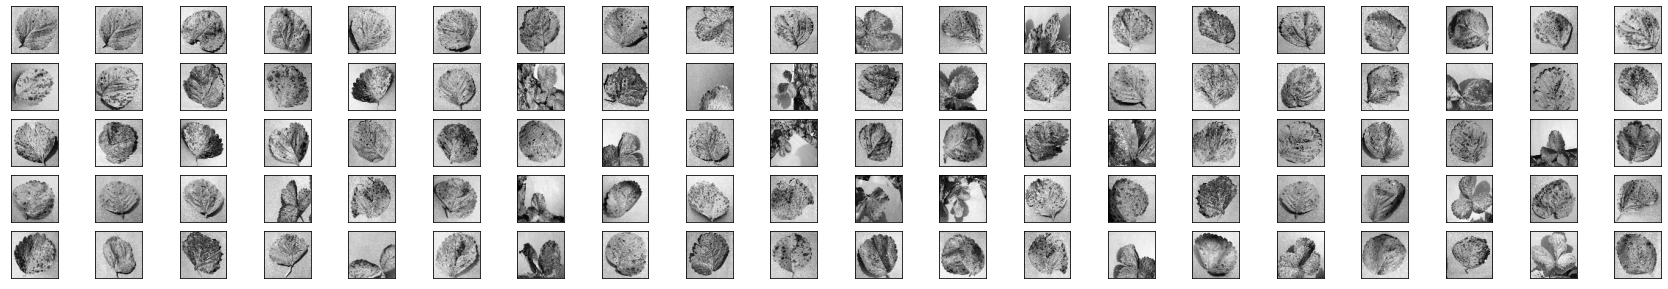

In [8]:
plt.figure()

fig, ax = plt.subplots(5, 20, subplot_kw=dict(xticks=[], yticks=[]),figsize=(30,5))
for i, axi in enumerate(ax.flat):
    axi.imshow(data[i].reshape(64,64), cmap='gray');


### Un premier modèle Isomap qui ne permet pas vraiment de comprendre comment les feuilles sont catégorisées 

In [ ]:
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray_r', prefit = False):
    ax = ax or plt.gca()
    
    if not prefit :
        proj = model.fit_transform(data)
    else:
        proj = data
    ax.plot(proj[:, 0], proj[:, 1], '.b')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # On ne montre pas le points trop proches
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

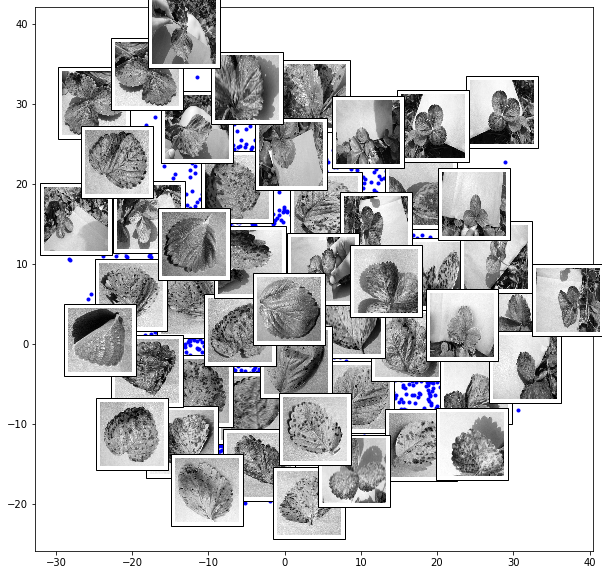

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_components(data,
                model=Isomap(n_components=2),
                images=data.reshape((-1, 64, 64)),
                cmap = 'gray',
                thumb_frac = .1)

### Un second modèle KMeans avec 2 clusters classe les images par rapport à leur environnement, il faut d'abord faire une reconnaissance de forme pour masquer l'environnement  

In [9]:
clf = KMeans(n_clusters = 2)
clf.fit(data)
labels = clf.labels_
centroids = clf.cluster_centers_

In [10]:
def n_malade(groupe):
  '''Cette fonction renvoi 1 dictionnaire avec le nom des fichiers de chaque cluster KMEANS'''
  n_group = {}
  pos = 0
  for i in groupe:
    if i == 0 :
      n_group.update({df.index[pos] : 0})
    else :
      n_group.update({df.index[pos] : 1}) 
    pos += 1
  return n_group

<Figure size 432x288 with 0 Axes>

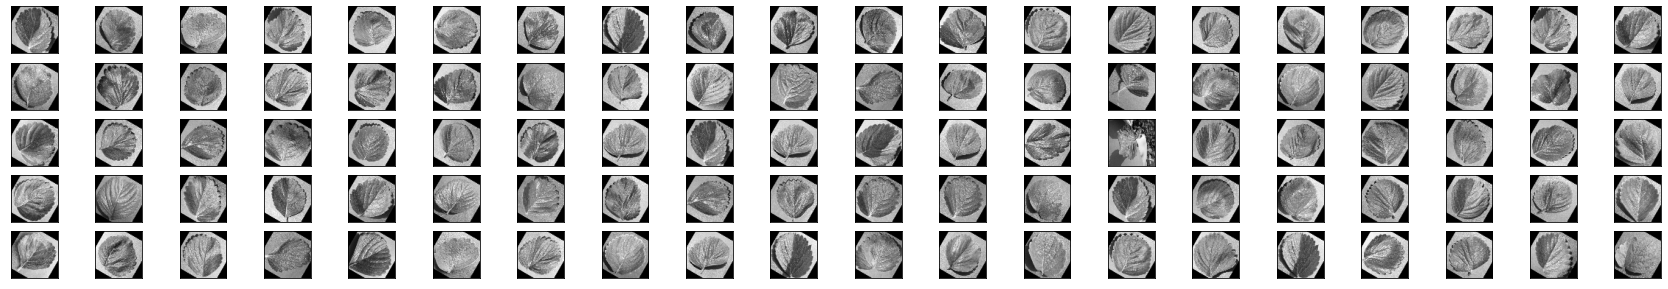

In [11]:
plt.figure()

fig, ax = plt.subplots(5, 20, subplot_kw=dict(xticks=[], yticks=[]),figsize=(30,5))
   
for i, axi in enumerate(ax.flat):
    j = i
    while labels[j] == 0 : 
      j =  random.randint(0,3598)
    axi.imshow(data[j].reshape(64,64), cmap='gray');

<Figure size 432x288 with 0 Axes>

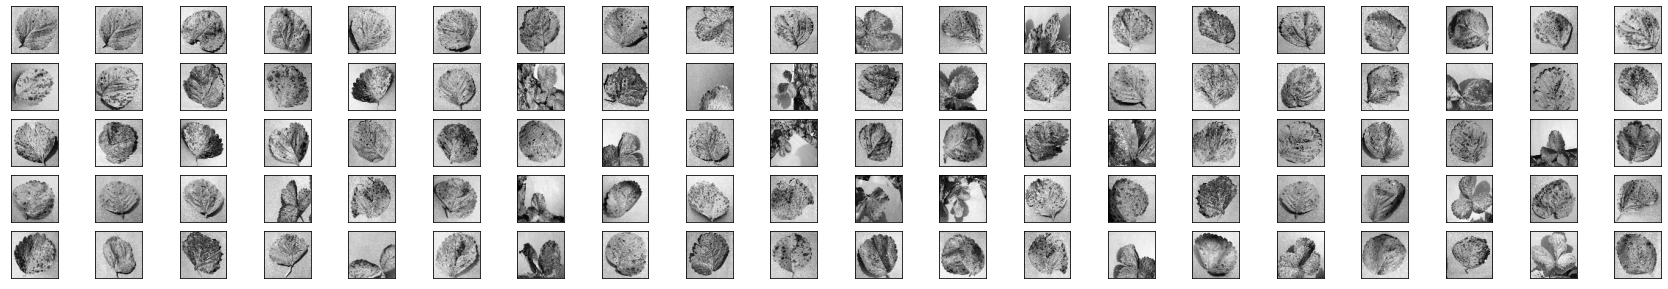

In [16]:
plt.figure()

fig, ax = plt.subplots(5, 20, subplot_kw=dict(xticks=[], yticks=[]),figsize=(30,5))
   
for i, axi in enumerate(ax.flat):
    j = i
    while labels[j] == 1 : 
      j =  random.randint(0,3598)
    axi.imshow(data[j].reshape(64,64), cmap='gray');

In [12]:
dico = n_malade(labels)

In [13]:
df_kmeans = pd.DataFrame(list(dico.items()),columns= ['FileName','group'])